In [36]:
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt

In [37]:
sensoren_skizze = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Entsprechende Excel-Spalten
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Mapping-Dictionary
skizze_to_excel = dict(zip(sensoren_skizze, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_skizze))

sensor_hoehen = np.array([ # Nummerierung wie in Skizze
    0.0, #TL (Referenzpunkt)
    1.0, 0.5, 0.0, 0.0, 0.5, 1.0, #T1 - T6
    1.41, 1.51, 1.61, #T7 - T9
    1.0, 0.5, 0.0, 0.0, 0.5, 1.0, #T10 - T15
    1.25, 1.35, #T16 - T17
    1.25, 1.35 #T18 - T19
])

In [38]:
#Liefert Sensordaten in Skizzenreihenfolge
def hole_sensorwerte(df, sensoren_skizze):
    excel_spalten = [skizze_to_excel[s] for s in sensoren_skizze]
    return df[excel_spalten].values


In [39]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

In [40]:
#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#gesamt_df


In [41]:
#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren
#gesamt_df



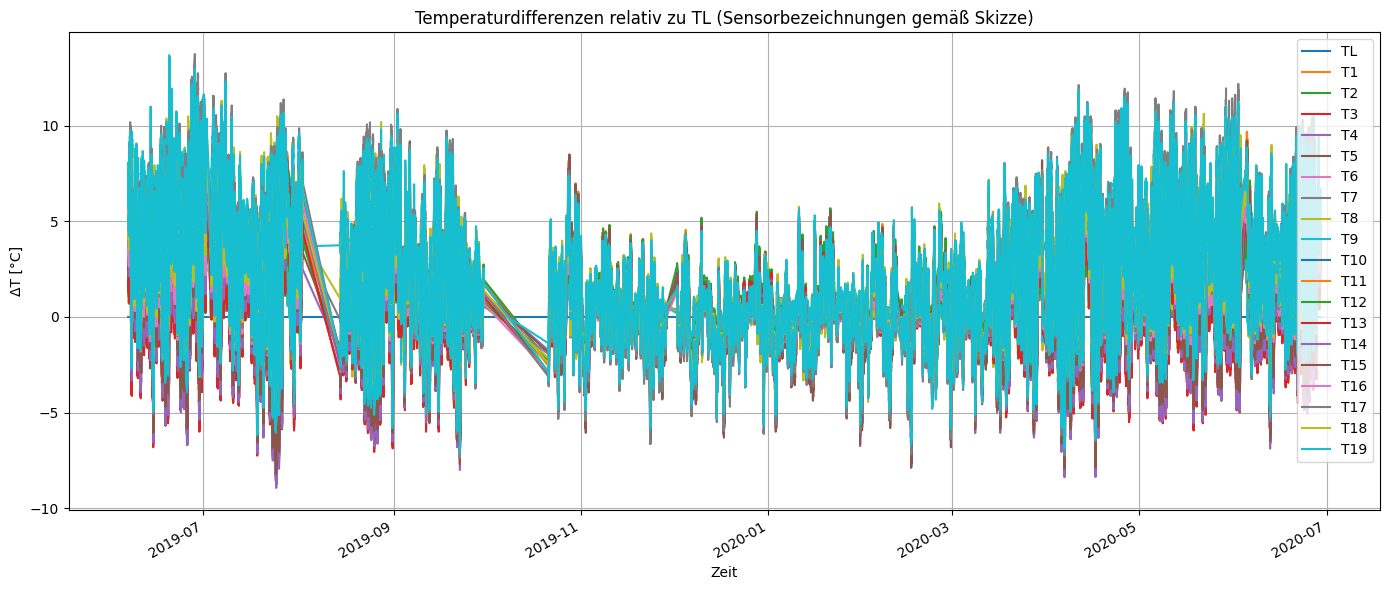

In [42]:
# -----------------------------------------------------
# Plot der Temperaturdifferenzen zu TL
# Bezeichnungen gemäß Skizze
# -----------------------------------------------------

# Sensordaten in Skizzenreihenfolge holen
werte_skizze = hole_sensorwerte(gesamt_df, sensoren_skizze)

# DataFrame mit Skizzenbezeichnungen erzeugen
df_skizze = pd.DataFrame(
    werte_skizze,
    index=gesamt_df.index,
    columns=sensoren_skizze
)

# Temperaturdifferenzen relativ zu TL
df_diff = df_skizze.sub(df_skizze["TL"], axis=0)

# Plot
df_diff.loc["2019-06-06":"2020-06-28"].plot(
    figsize=(14, 6),
    title="Temperaturdifferenzen relativ zu TL (Sensorbezeichnungen gemäß Skizze)",
)

plt.ylabel("ΔT [°C]")
plt.xlabel("Zeit")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
gradienten = []

werte = hole_sensorwerte(gesamt_df, sensoren_skizze)

for temps in werte:
    if np.isnan(temps).any():
        gradienten.append(np.nan)
        continue

    # TL ist erstes Element -> Referenz
    temps_rel = temps - temps[0]

    _, a = polyfit(sensor_hoehen, temps_rel, 1)
    gradienten.append(a)

gesamt_df["temp_gradient"] = gradienten


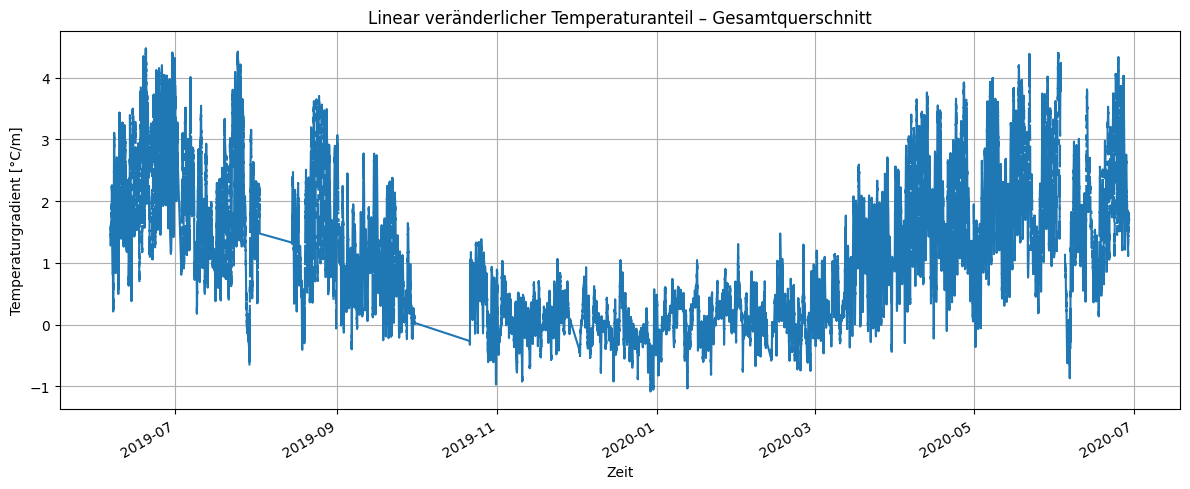

In [45]:
plt.figure(figsize=(12, 5))
gesamt_df["temp_gradient"].plot()
plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Linear veränderlicher Temperaturanteil – Gesamtquerschnitt")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Schwerpunkt Aufgabe 1 – Teilquerschnitte

# T7, T8, T9 liegen in der QS-Mitte (hier nicht relevant)
# TL ist Referenzsensor (z = 0)

sensoren_links_skizze = ["TL", "T1", "T2", "T3", "T4", "T5", "T6", "T18", "T19"]
sensoren_rechts_skizze = ["TL", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17"]

hoehen_links = np.array([0.0, 1.0, 0.5, 0.0, 0.0, 0.5, 1.0, 1.25, 1.35])
hoehen_rechts = hoehen_links.copy()

# Hilfsfunktion: linearer Temperaturgradient

def berechne_gradient_skizze(df, sensoren_skizze_subset):
    idx = [sensoren_skizze.index(s) for s in sensoren_skizze_subset]
    hoehen = sensor_hoehen[idx]

    gradients = []
    werte = hole_sensorwerte(df, sensoren_skizze_subset)

    for temps in werte:
        if np.isnan(temps).any():
            gradients.append(np.nan)
            continue

        temps_rel = temps - temps[0]
        _, a = polyfit(hoehen, temps_rel, 1)
        gradients.append(a)

    return gradients


# Gradienten berechnen
gesamt_df["grad_linker_steg"] = berechne_gradient_skizze(
    gesamt_df, sensoren_links_skizze
)

gesamt_df["grad_rechter_steg"] = berechne_gradient_skizze(
    gesamt_df, sensoren_rechts_skizze
)

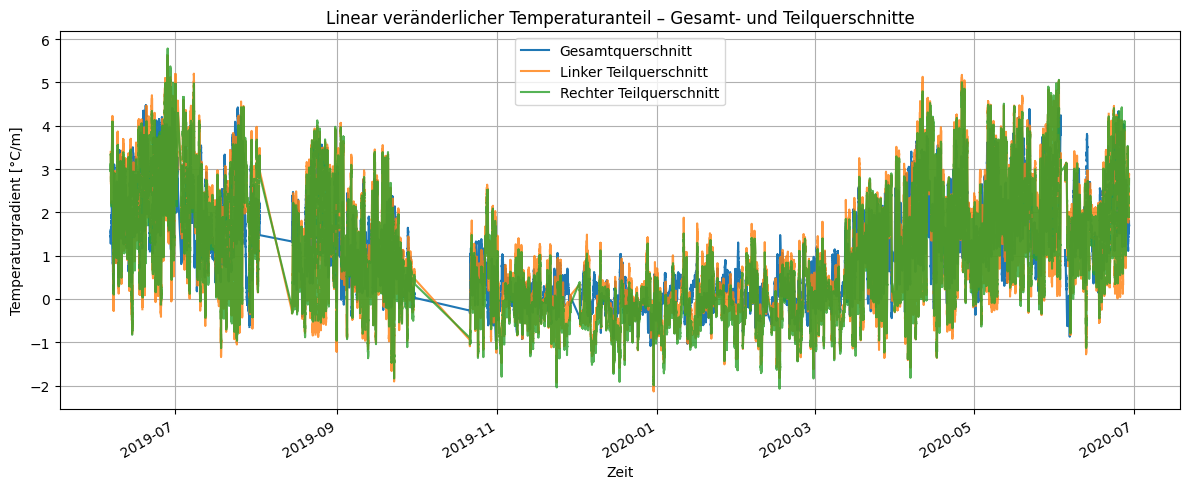

In [48]:
# Visualisierung: Vergleich
plt.figure(figsize=(12, 5))

gesamt_df["temp_gradient"].plot(
    label="Gesamtquerschnitt", linewidth=1.5
)
gesamt_df["grad_linker_steg"].plot(
    label="Linker Teilquerschnitt", alpha=0.8
)
gesamt_df["grad_rechter_steg"].plot(
    label="Rechter Teilquerschnitt", alpha=0.8
)

plt.ylabel("Temperaturgradient [°C/m]")
plt.xlabel("Zeit")
plt.title("Linear veränderlicher Temperaturanteil – Gesamt- und Teilquerschnitte")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()